In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
date = datetime.today().strftime('%Y-%m-%d') + 'T03:00:00Z'
file_list = [f"C:/Users/alexl/Documents/GitHub/Meteo/maps/arome_data/{date.replace(':', '-')}/{file.replace(':', '-')}" for file in os.listdir(f"C:/Users/alexl/Documents/GitHub/Meteo/maps/arome_data/{date.replace(':', '-')}")]
backend_kwargs1 = {
    'filter_by_keys': {
        'paramId': 167,
        'level': 2
    }
}
backend_kwargs2 = {
    'filter_by_keys': {
        'paramId': 228228
    }
}

datasets1 = [xr.open_dataset(f, engine='cfgrib', backend_kwargs=backend_kwargs1) for f in file_list]
ds1 = xr.concat(datasets1, dim='step')
datasets2 = [xr.open_dataset(f, engine='cfgrib', backend_kwargs=backend_kwargs2) for f in file_list]
ds2 = xr.concat(datasets2, dim='step')
ds = xr.merge([ds1, ds2])

In [3]:
dsf = ds.to_dataframe()
dsf = dsf.reset_index()

In [4]:
mean_dsf = dsf.groupby(['latitude', 'longitude']).mean().reset_index()[['latitude', 'longitude', 't2m', 'tp']]
mean_dsf['latitude'] = round(mean_dsf['latitude'], 3)
mean_dsf['longitude'] = round(mean_dsf['longitude'], 3)

In [5]:
dep_coords = pd.read_csv('coords_dep_0025.csv', low_memory=False)

In [6]:
lst = []
for i in dep_coords['Dep'].unique():
    dep_coords_dep = dep_coords[dep_coords['Dep'] == i]
    dsf_dep = pd.merge(mean_dsf, dep_coords_dep, on=['latitude', 'longitude'], how='inner')
    mean_temp_dep = dsf_dep['t2m'].mean() - 273.15
    mean_precip_dep = dsf_dep['tp'].mean()
    data = [i, mean_temp_dep, mean_precip_dep]
    lst.append(data)
df_mean_arome = pd.DataFrame(lst, columns=['DEPARTEMENT', 'TmpMean', 'PrecipMean'])

##### On s'occupe de la corse

In [7]:
corsica = df_mean_arome[(df_mean_arome['DEPARTEMENT'] == '2A') | (df_mean_arome['DEPARTEMENT'] == '2B')][['TmpMean', 'PrecipMean']].mean()
corsica_df = pd.DataFrame({
    'DEPARTEMENT': ['20'],
    'TmpMean': [corsica['TmpMean']],
    'PrecipMean': [corsica['PrecipMean']]
})
df_mean_arome = pd.concat([df_mean_arome, corsica_df]).reset_index(drop=True)
df_mean_arome = df_mean_arome[~df_mean_arome['DEPARTEMENT'].isin(['2A', '2B'])].copy()

In [8]:
df_mean_arome.loc[:, 'DEPARTEMENT'] = df_mean_arome['DEPARTEMENT'].astype('int8')

In [9]:
df = dd.read_csv('C:/Users/alexl/Documents/GitHub/Meteo/meteo_france/RR_TM_ALTI/rr_tm_alti_1950_2022.csv', usecols=['NUM_POSTE', 'DEPARTEMENT', 'ALTI', 'AAAAMMJJ', 'RR', 'TM'], dtype={'DEPARTEMENT':'int8','ALTI':'int32', 'RR':'float32', 'TM': 'float32'}, parse_dates=['AAAAMMJJ'])

In [10]:
same_day_mask = (df['AAAAMMJJ'].dt.month == datetime.today().month) & (df['AAAAMMJJ'].dt.day == datetime.today().day)
next_day_mask = (df['AAAAMMJJ'].dt.month == (datetime.today() + timedelta(days=1)).month) & (df['AAAAMMJJ'].dt.day == (datetime.today() + timedelta(days=1)).day)
two_days_after_mask = (df['AAAAMMJJ'].dt.month == (datetime.today() + timedelta(days=2)).month) & (df['AAAAMMJJ'].dt.day == (datetime.today() + timedelta(days=2)).day)

combined_mask = same_day_mask | next_day_mask | two_days_after_mask

df_today_historical_plus_48h = df[combined_mask]

In [11]:
mean_historical = df_today_historical_plus_48h.groupby('DEPARTEMENT')['RR', 'TM'].mean(numeric_only=True)

In [12]:
df_mean_historical = mean_historical.compute()

In [13]:
df_mean_historical = df_mean_historical.reset_index()

In [14]:
df = pd.merge(df_mean_arome, df_mean_historical, on=['DEPARTEMENT'], how='inner')

In [15]:
df['TmpAnomaly'] = df['TmpMean'] - df['TM']
df['PrecipAnomaly'] = df['PrecipMean'] - df['RR']
df['PrecipAnomaly%'] = round((((df['PrecipMean'] - df['RR']) / df['RR']) * 100), 2)

### CARTOPY MAP

In [16]:
departments = gpd.read_file('geojsonfrance_corse_20.json')[['code', 'geometry']]
departments['code'] = departments['code'].astype('int8')

In [17]:
merged = departments.merge(df, how='left', left_on='code', right_on='DEPARTEMENT')

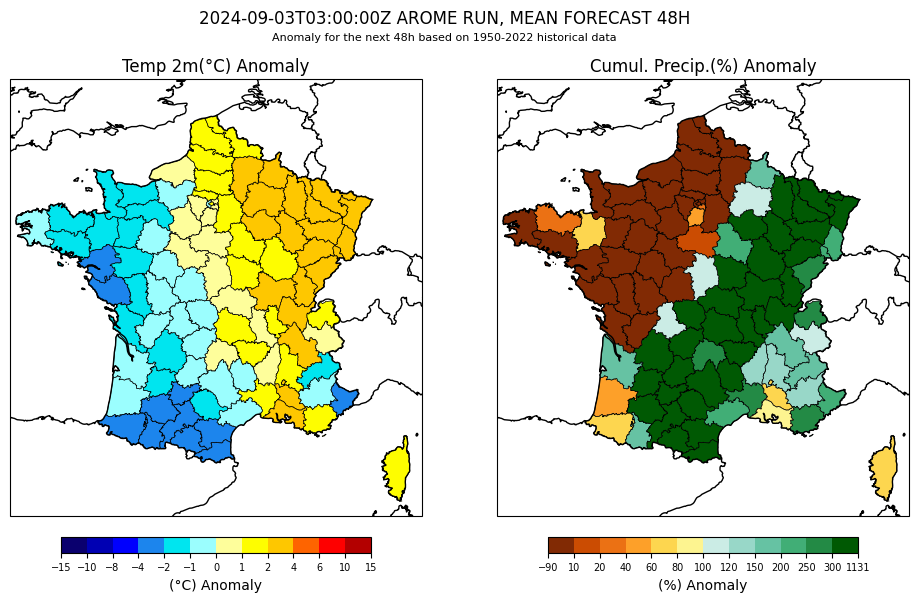

In [41]:
#Colors for the persolised colormap
tempcmp = np.array([[10/256, 0, 110/256, 1], [0,0,180/256,1], [0, 0, 255/256, 1], [28/256, 134/256, 238/256, 1], [0, 230/256, 240/256, 1], 
                    [156/256, 255/256, 255/256, 1], [255/256, 255/256, 156/256, 1], [255/256, 254/256, 0, 1], [255/256, 200/256, 0, 1], 
                    [255/256, 100/256, 0, 1], [255/256, 0, 0, 1], [180/256, 0, 0, 1]])
precipcmp = np.array([[130/256,42/256,4/256,1], [204/256,76/256,2/256,1], [236/256,113/256,20/256,1], [254/256,161/256,41/256,1], [254/256,215/256,79/256,1], 
                    [254/256, 245/256, 145/256,1], [204/256, 237/256, 230/256,1], [153/256, 216/256, 201/256,1], [102/256, 195/256, 164/256,1], 
                    [65/256, 175/256, 118/256,1], [35/256, 139/256, 69/256, 1], [0, 89/256, 3/256,1]])
tempcmp = ListedColormap(tempcmp)
precipcmp = ListedColormap(precipcmp)

fig, axes = plt.subplots(1, 2, figsize=(12, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the extent of the map to be France centered
extent = [-5, 10, 41, 52]

#Boundaries for the cmap
tempBoundaries = [-15, -10, -8, -4, -2, -1, 0, 1, 2, 4, 6, 10, 15]
precipBoundaries = [round(merged['PrecipAnomaly%'].min(),0), 10, 20, 40, 60, 80, 100, 120, 150, 200, 250, 300, round(merged['PrecipAnomaly%'].max(),0)]

# Colormap normalisation
normTemp = BoundaryNorm(tempBoundaries, tempcmp.N)
normPrecip = BoundaryNorm(precipBoundaries, precipcmp.N)

# Loop through each axis and apply the settings
for ax in axes:
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    
merged.plot(column='TmpAnomaly', ax=axes[0], cmap=tempcmp, norm=normTemp, edgecolor='black', linewidth=0.5)
merged.plot(column='PrecipAnomaly%', ax=axes[1], cmap=precipcmp, norm=normPrecip, edgecolor='black', linewidth=0.5)

# Set titles
axes[0].set_title('Temp 2m(°C) Anomaly')
axes[1].set_title('Cumul. Precip.(%) Anomaly')

#Colormap and colorbar properties
smTemp = plt.cm.ScalarMappable(cmap=tempcmp, norm=normTemp)
smTemp.set_array([])
smPrecip = plt.cm.ScalarMappable(cmap=precipcmp, norm=normPrecip)
smPrecip.set_array([])
cbarTemp = plt.colorbar(smTemp, ax=axes[0], location='bottom', pad=0.04, shrink=0.70, label='(°C) Anomaly')
cbarTemp.set_ticks(tempBoundaries)
cbarTemp.ax.tick_params(labelsize=7)
cbarPrecip = plt.colorbar(smPrecip, ax=axes[1], location='bottom', pad=0.04, shrink=0.70, label='(%) Anomaly')
cbarPrecip.set_ticks(precipBoundaries)
cbarPrecip.ax.tick_params(labelsize=7)

# Titles and subplots spacing
plt.suptitle(f'{date} AROME RUN, MEAN FORECAST 48H')
plt.text(0.5, 0.94, 'Anomaly for the next 48h based on 1950-2022 historical data', ha='center', va='center', fontsize=8, transform=plt.gcf().transFigure)
plt.subplots_adjust(wspace=0.1) 

if not os.path.isdir(f"C:/Users/alexl/Documents/GitHub/Meteo/maps/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}"):
    os.mkdir(f"C:/Users/alexl/Documents/GitHub/Meteo/maps/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}")
plt.savefig(f"C:/Users/alexl/Documents/GitHub/Meteo/maps/img/{pd.to_datetime(date).year}-{pd.to_datetime(date).month}/{pd.to_datetime(date).day}.png")